# 6 - Attention is All You Need

In this notebook we will be implementing a (slightly modified version) of the Transformer model from the [Attention is All You Need](https://arxiv.org/abs/1706.03762) paper. All images in this notebook will be taken from the Transformer paper. For more information about the Transformer, [see](https://www.mihaileric.com/posts/transformers-attention-in-disguise/) [these](https://jalammar.github.io/illustrated-transformer/) [three](http://nlp.seas.harvard.edu/2018/04/03/attention.html) articles.

![](assets/transformer1.png)

## Preparing the Data

As always, let's import all the required modules and set the random seeds for reproducability.

모델 구현 및 inference에 필요한 라이브러리를 불러오는 코드이다. 저번 과제와 마찬가지로 Muti30K 데이터셋을 활용해서 독일어를 영어로 번역하는 task를 수행한다. 데이터셋 정보는 다음과 같다.

train: 29000

valid: 1014

test: 1000

약 3만여개의 영어, 독일어 문장으로 구성되어있으며, 문장 당 평균 단어(token)수는 13개 정도이다.

## 1. 필요한 모듈 불러오기

In [54]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

## 2. random seed 설정

In [55]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

고정 할 랜덤시드를 선언한다. numpy와 torch에 적용된다.

We'll then create our tokenizers as before.

## 3. 데이터셋 불러오기 및 전처리

In [3]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [4]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

spacy 내 구현된 english tokenizer와 독일어 tokenizer를 load한다. 이후 정의된 함수들은 입력된 text를 tokenizer를 사용해서 token으로 분리한 후, 리턴하는 코드이다.

In [5]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

사용자 정의함수를 tokenizer로 쓰고, init_token과 eos_token을 선언하는 Field 객체이다. 이때 transformer의 input shpae을 고려해서 batch_first를 True 해준다.

In [7]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

정의한 필드를 사용하여 데이터셋을 train, valid, test로 분리하는 코드이다. 이때 필드는 source와 target에 대해 각각 다르게 적용된다.

## 4. 단어사전 생성

In [8]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

토크나이징 이후 각 고유 토큰에 대해 정수인코딩을 진행해서  단어사전을 만든다. 

## 5. 데이터로더 정의

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

GPU 사용이 가능하면 gpu, 아니면 cpu를 사용한다.

In [10]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

데이터들을 담아놓은 Bucket에서 BATCH_SIZE만큼 모아지도록 데이터를 뽑아주는 BucketIterator로 split한다.

## 6. Transformer 모델 구조

### Building the Model

Next, we'll build the model. Like previous notebooks it is made up of an *encoder* and a *decoder*, with the encoder *encoding* the input/source sentence (in German) into *context vector* and the decoder then *decoding* this context vector to output our output/target sentence (in English). 

#### Encoder


![](assets/transformer-encoder.png)



트랜스포머의 인코더는 정수인코딩 된 문장을 input으로 받는다. 이때 Multi-head attention layer로 들어가기 전, 두가지 단계의 embedding layer가 존재한다. 

1.token embedding layer : token embedding하는 일반적인 layer [batch size x seq_len x d_model]

2.positional embedding layer : 각 토큰의 위치정보를 넣어주기 위한 layer [batch size x seq_len x d_model]



정수인코딩 된 input 데이터는 token embedding layer를 거쳐서 𝑑_𝑚𝑜𝑑𝑒𝑙의 dimension size를 가지는 token embedding vector로 변환이 되고, 입력 문장의 max_length에 따라서 positional embedding vector를 생성, token embedding vector와 합해진다. 이때 합쳐지기 전, token embedding vector는 scaling factor인 hidden_dim의 제곱근을 곱한 뒤 합해지는데, 이 과정을 거치는 이유는 embedding 내 variance를 줄이고 모델이 학습을 더 잘 할 수 있도록 돕기 위함이다. 결과적으로 합해진 embedding vector에 dropout layer가 적용 된 뒤 mutl head attention layer의 input으로 사용된다. 이때 인코더에서는 마스킹을 진행하는데 이는 패딩 마스킹이다.


In [68]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

Encoder class에서 입력받는 hyperparameter는 다음과 같다.

* input dim: input token으로 구성한 단어사전의 dimension을 의미한다. 즉,src_token의 vocab size가 된다.

* hid_dim: 임베딩 벡터의 dimension을 의미한다. original transformer에서는 512로 사용한다.

* n_layers: 인코더, 디코더의 개수를 의미한다.

* n_heads:멀티 헤드 어텐션 수행시 사용하는 헤드의 개수를 의미한다.

* pf_dim: 인코더 디코더 내 피드포워드 신경망의 dimension 크기를 의미한다.

* dropout:특정 feature에 대해 과적합을 방지하기 위한 dropout 비율을 의미한다.

* device: cpu, gpu 중 선택해서 사용한다.

* max_length:입력으로 사용하는 시퀀스의 최대 길이를 의미한다.

Encoder 클래스에서는 input_dim을 hidden_dim으로 바꿔주는 임베딩 레이어와 시퀀스 내 각 토큰 별 위치 정보를 알려주는 positional 임베딩 레이어가 존재한다.  
<br>
또한 인코더의 세부 레이어들에 대해서 정의된 nn.ModuleList()가 self.layer() 형태로 정의되어 있으며 self.scale은 hid_dim 크기의 제곱근 만큼 스케일링 해주는 역할을 한다.  
<br>
input 시퀀스는 token embedding layer를 통해 임베딩 벡터로 변환되고 여기에 스케일링 값을 곱해준 뒤 positional 임베딩과 더해진다. 이후 dropout을 거쳐 encoder layer의 직접적인 input인 src를 생성한다.  
<br>
생성된 src는 for문을 통해 각 세부 encoder layer를 통과해서 결과를 리턴한다.

### Encoder Layer



* 하나의 encoder layer에는 Multi-head self-attention layer, residual connection & layer normalization, position-wise feedworad layer가 존재한다. 
* 입력 시퀀스와 마스킹 정보는 multi-head attention을 수행하고 어텐션 결과값을 산출한다.  
* 이때 어텐션 결과는 src의 dimension과 동일하게 hid_dim을 가진다. 헤드를 여러개 사용해도 같다.
* 어텐션 결과값은 src 임베딩과 더해지는 residual connection과정을 거치고, layer normalization을 통해 feature 값 끼리 정규화되는 연산을 수행한다.  
* 이후 fully-connected layer인 position-wise feedfowrad layer를 통과한다. 피드포워드 신경망의 dimension은 보통 hid_dim보다 크다. 이때 피드 포워드 신경망의 파라메터는 하나의 층에서 입력이 달라질 때 동일한 값이 적용되고 인코더 층마다는 달라진다.


In [12]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

- Encoderlayer 클래스에서 역시 Encoder 클래스와 동일한 파라메터로 초기화 된다. 또한 인코더 내부를 구성하는 셀프어텐션 레이어, 피드포워드 레이어, 그리고 각 레이어 윗단에 사용되는 잔차연결 및 레이어 정규화 층이 선언된다.  
  
  
- foward 함수를 살펴보면 self.self_attention()의 입력으로 src 3개와 src_mask 1개가 있는데, 이는 어텐션에 사용할 key, query, value를 만들기위한 입력으로 주어지는 것이다. src_mask의 경우, 어텐션 결과(energy)에 마스킹을 주기 위해 입력한다.  


- 어텐션 결과값은 [batch_size, seq len, hid dim]의 shape을 가지며, 드롭아웃 레이어를 거친 뒤 input과 element-wise sum 되어 잔차 연결을 이룬다. 이후 self.self_attn_layer_norm()을 통해 layer normalization을 된 결과를 출력한다. 이때 역시 데이터의 shape은 encoder layer에 들어가기 전 src와 동일하다.

- 이후 출력 값은 position wise feedworad layer로 들어가게 되고 hid dim 차원의 벡터는 레이어 안에서 pf_dim 크기로 변환되는데 출력시에는 다시 hid dim으로 변환되어 출력된다. 이때 역시 어텐션 레이어와 동일하게 드롭아웃과 잔차연결, 레이어 노말라이제이션이 적용된다.

### Mutli Head Attention Layer

One of the key, novel concepts introduced by the Transformer paper is the *multi-head attention layer*. 

![](assets/transformer-attention.png)

Attention can be though of as *queries*, *keys* and *values* - where the query is used with the key to get an attention vector (usually the output of a *softmax* operation and has all values between 0 and 1 which sum to 1) which is then used to get a weighted sum of the values.

The Transformer uses *scaled dot-product attention*, where the query and key are combined by taking the dot product between them, then applying the softmax operation and scaling by $d_k$ before finally then multiplying by the value. $d_k$ is the *head dimension*, `head_dim`, which we will shortly explain further.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

This is similar to standard *dot product attention* but is scaled by $d_k$, which the paper states is used to stop the results of the dot products growing large, causing gradients to become too small.

However, the scaled dot-product attention isn't simply applied to the queries, keys and values. Instead of doing a single attention application the queries, keys and values have their `hid_dim` split into $h$ *heads* and the scaled dot-product attention is calculated over all heads in parallel. This means instead of paying attention to one concept per attention application, we pay attention to $h$. We then re-combine the heads into their `hid_dim` shape, thus each `hid_dim` is potentially paying attention to $h$ different concepts.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ is the linear layer applied at the end of the multi-head attention layer, `fc`. $W^Q, W^K, W^V$ are the linear layers `fc_q`, `fc_k` and `fc_v`.

Walking through the module, first we calculate $QW^Q$, $KW^K$ and $VW^V$ with the linear layers, `fc_q`, `fc_k` and `fc_v`, to give us `Q`, `K` and `V`. Next, we split the `hid_dim` of the query, key and value into `n_heads` using `.view` and correctly permute them so they can be multiplied together. We then calculate the `energy` (the un-normalized attention) by multiplying `Q` and `K` together and scaling it by the square root of `head_dim`, which is calulated as `hid_dim // n_heads`. We then mask the energy so we do not pay attention over any elements of the sequeuence we shouldn't, then apply the softmax and dropout. We then apply the attention to the value heads, `V`, before combining the `n_heads` together. Finally, we multiply this $W^O$, represented by `fc_o`. 

Note that in our implementation the lengths of the keys and values are always the same, thus when matrix multiplying the output of the softmax, `attention`, with `V` we will always have valid dimension sizes for matrix multiplication. This multiplication is carried out using `torch.matmul` which, when both tensors are >2-dimensional, does a batched matrix multiplication over the last two dimensions of each tensor. This will be a **[query len, key len] x [value len, head dim]** batched matrix multiplication over the batch size and each head which provides the **[batch size, n heads, query len, head dim]** result.

One thing that looks strange at first is that dropout is applied directly to the attention. This means that our attention vector will most probably not sum to 1 and we may pay full attention to a token but the attention over that token is set to 0 by dropout. This is never explained, or even mentioned, in the paper however is used by the [official implementation](https://github.com/tensorflow/tensor2tensor/) and every Transformer implementation since, [including BERT](https://github.com/google-research/bert/).

- 소개되는 멀티헤드 어텐션은 시퀀스 내 등장하는 모든 단어 벡터 src를 weight matrix를 통과시켜 각각 key, query, value를 얻음으로써 첫 프로세스가 진행 된다.  

- 이때 멀티 헤드의 개념은 특정 feature에 치우쳐서 단어사이의 관계를 보지 않고, 다양한 시각에서 단어 사이의 관계를 보겠다는 의미이다. 따라서 헤드 수 만큼 K, Q, V matrix가 존재하고, weight matrix를 통과한 벡터의 차원은 hid_dim에서 hid_dim/num_head = head_dim 크기로 변환된다.

- 뽑힌 K, Q metrix는  둘 중 하나의 행렬을 전치시킨 뒤 행렬 간 곱을 통해서 어텐션 스코어를 산출하고 이는 head_dim의 제곱근으로 나눠진다. 해당 과정 때문에 스케일드 닷 프로덕트 어텐션이라는 이름으로 불리우게 되었다.

- 위 과정을 거친 결과물인 energy는 소프트맥스 함수를 통해 attention weight로 표현이 되며, key와 query 내 각각의 token 사이의 관계를 나타내는 스칼라 값을 가진다.

- 해당 값은 Value matrix와 곱해져서 각 헤드 별 어텐션 결과를 산출하게 된다.

- 각 헤드들의 결과물은 다시 hid_dim 크기의 matrix로 표현되기 위해서 서로 concat 된다.모두 연결된 matrix는 fc layer의 hid_dim x hid dim 가중치 행렬과 곱해져서 [batch size x seq_len x hid dim] shape의 결과를 출력한다.

In [13]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

Multihead attention 클래스 구현 코드이다.  

- hid_dim % num_heads 나머지는 0이라고 지정하고, hid dim, num_heads, head_dim을 필드로 받는다.
- 또한 q, k, v를 만들기 위해 각각의 linear layer를 선언한다 연산 마지막에 적용하는 fc 역시 선언한다. 이때 input, output shape은 hid dim으로 동일하다. 이후 dropout layer와 scale 필드를 선언한다.  


- foward 부분에서는 각각의 weight matrix에 인풋을 태워 q, k, v를 만든다. 이후 매트릭스간 연산을 위해서 view 함수와 permute함수를 통해 각 matrix의 shape을 변경해준다. => [batch size, n heads, (), head dim] : ()는 각각 query len, key len, value len 이다.  


- 이후 Q와 K를 행렬곱하기 위해서 K를 [batch size, n_heads, head dim, key len] shape으로 변경해준다. 해당 변경은 permute() 함수가 수행한다.  
- 변경 후에는 Q ( query_len x head dim) x K( head_dim x key_len ) = [batch size, n_heads, query len, key len] shape의 matrix가 계산되어 각 token pair 별 relationship이 출력되고, 여기에 head_dim의 제곱근인 self.scale을 나눠 주어 energy를 구한다.  

- 특정 위치의 masking 정보가 0이면 energy matrix에서의 해당 위치값을 매우작은 실수로 바꾸어 마스킹한다.  

- Value matrix는 마스킹된 energy 값에 드롭아웃 레이어를 통과시킨 matrix와 행렬곱을하고 이때의 shape은 [batch_size, n heads, query len, head dim]이다. multihead self attention에서 query len == value len == key len 이다.  

- 이후 shape 변경을 통해서 matrix는 [batch size, query len , hid dim]의 shape을 갖게 된다.

- 마지막으로 output fc layer를 통과시켜 어텐션 연산 결과 matrix를 출력한다. 이때 fc layer의 weight matrix는 [hid_dim x hid dim]이다.


### Position-wise Feedforward Layer



- 포지션 와이즈 피드포워드 레이어는 멀티 헤드 어텐션 레이어 이후에 잔차연결과 레이어 노말라이제이션을 거친 매트릭스를 인풋으로 받는다.  


- 해당 신경망의 dimension은 hid dim과 다르게 pf dim으로 달리 설정된다. 따라서 인풋이 들어오는 레이어는 [hid_dim, pf_dim]으로 벡터 차원을 변경 시키고, 아웃풋을 만드는 레이어는 [pf_dim, hid_dim] 크기의 weight matrix로 아웃풋 차원을 변경시킨다.  


- 이때 FFNN의 output 레이어를 통과하기 전 relu activation function과 드롭아웃 레이어가 적용된다. 

In [14]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

- PositionwiseFeedforwardLayer의 초기화 시에 hid_dim x pf_dim의 가중치행렬을 가지는 입력레이어와 pf_dim x hid_dim을 가지는 출력레이어가 각각 선언된다.  

- foward 부분에서는 입력 레이어를 통과해 pf_dim 크기로 변환된 matrix가 relu activation function 및 dropout을 거치고 출력 레이어인 self.fc_2()를 통과하여 [batch size, seq len, hid dim] shape의 matrix를 리턴하는 것을 확인할 수 있다.

### Decoder

The objective of the decoder is to take the encoded representation of the source sentence, $Z$, and convert it into predicted tokens in the target sentence, $\hat{Y}$. We then compare $\hat{Y}$ with the actual tokens in the target sentence, $Y$, to calculate our loss, which will be used to calculate the gradients of our parameters and then use our optimizer to update our weights in order to improve our predictions. 

![](assets/transformer-decoder.png)



- Decoder의 구조는 encoder와 유사하지만 masked multi head attention layer가 추가로 붙어있다.  


- 디코더 역시 positional embedding을 사용하며, next token generation task를 수행하지만 입력으로 전체 시퀀스를 준다. 이때 연산 과정에서 미래시점의 token 정보에 attention 값이 발생하는 것을 방지하기 위해서 현재 시점보다 미래에 있는 단어들을 참고하지 못하도록 룩 어 헤드 마스킹을 전체 시퀀스에 대해 수행한다.  

- 해당 마스킹 과정은 디코더의 첫번째 서브층에서 이루어지는 데, 디코더의 첫번째 서브층인 멀티 헤드 셀프 어텐션층에서 이루어지는 것이다. 이는 인코더의 어텐션층에서 연산하는 과정과 동일하지만 입력 매트릭스에 마스킹을 씌운다는 점만 다르다.

- positional encoding시 사용하는 length는 단어 사전의 길이인데, 이는 곧 입력을 단어사전의 길이만큼 입력받을 수 있다는 것을 의미하기도 한다.  

- 디코더의 두번째 서브층에서 이뤄지는 멀티헤드 어텐션은 인코더 출력값을 k,v로 사용하고 첫번째 서브층인 masked multi head attention layer의 출력값을 Q로 사용한다는 특징이 있다.

In [15]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

- 디코더 클래스를 초기화 할때 입력받는 인자들은 인코더와 동일하다. 토큰 임베딩 레이어와 포지셔널 임베딩 레이어, ModuleList, dropout과 scale 등 선언하는 layer 역시 동일하다.

- forward 과정 역시 거의 차이가 없으나 self.layers에서 수행하는 attention 결과를 softmax를 통과한 target의 distribution인 output과 함께 출력한다는 차이점이 있다. 이때 output dim 은 출력 언어의 단어사전 길이만큼 설정된다.  

- enc_src의 경우 encoder에서 출력된 matrix를 의미하고 scr_mask는 디코더의 두번째 서브층에서 어텐션을 수행할 시 enc_src에 마스킹을 주기 위해 사용한다. trg는 출력 시퀀스의 정수인코딩 값을 의미하며 trg_mask의 경우 룩어헤드 마스킹 정보를 첫번 째 서브층에서 마스킹할 때 전달하기 위해 사용하는 값이다.

### Decoder Layer



- 디코더의 세부 레이어는 인코더와 masked 멀티 헤드 어텐션 레이어가 추가된 구조이다. 해당 레이어가 첫번째 서브층이 되고, 두번째 서브층이 멀티헤드어텐션레이어 인데, key와 value로 enc_src를 사용하며 query로 디코더 첫번째 서브층의 출력 매트릭스를 사용한다.  

- 드롭아웃 레이어와 잔차연결, 레이어 노말라이제이션 역시 각 서브층 사이에 존재한다.  

- 첫번째 서브층은 trg_mask, 즉 타겟 시퀀스에 대한 마스킹을 입력 매트릭스에 대해 진행 한뒤 입력으로 사용한다. 이는 앞에서도 말했듯 미래시점의 토큰에 pay attention하는것을 방지한다. 

- 두번째 서브층에서 src_mask가 사용되고, 이는 패딩 토큰에 pay attention하는것을 방지한다.

- 세번째 서브층은 포지션 와이즈 피드포워드 신경망이며 이를 통과한 뒤 역시 잔차연결, 레이어 노말라이제이션, 드롭아웃을 거쳐 output fc layer의 input을 생성한다.

In [16]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

- 디코더 레이어 클래스역시 인코더 레이어 클래스와 유사하나 self.encoder_attention 이라는 인코더 정보와 디코더 인풋을 같이 사용하는 레이어가 추가된 구조이다. 다른부분은 모두 인코더와 같다.  

- 포워드 부분을 보면 self.self_attention()에서 디코더 입력에 대한 키, 쿼리, 벨류를 생성하여 어텐션 결과인 _trg를 출력하는 masked multi head self attention 레이어를 선언한다. 이때 trg의 shape은 [batch size, trg len, hid dim]이며, output 역시 동일하다. 이때 input으로 trg_mask 정보를 함께 준다.  

- 두번째 서브층은 self.enc_attention으로 쿼리, 키, 벨류 순으로 trg, enc_src, enc_src를 입력하며 src_mask를 함께 준다.  

- 세번째 서브층은 self.positionwise_feedfoward()로 인코더와 동일한 연산과정을 거친다.

- 각 서브층 사이에는 dropout, 잔차연결, layer normalization이 구현되어있다. ( self.dropout(), self.{}_layer_norm)

- 최종적으로 출력되는 trg의 shape은 디코더 초기 input과 동일하게 [batch size, trg len, hid dim] 이다.

### Seq2Seq

Finally, we have the `Seq2Seq` module which encapsulates the encoder and decoder, as well as handling the creation of the masks.

The source mask is created by checking where the source sequence is not equal to a `<pad>` token. It is 1 where the token is not a `<pad>` token and 0 when it is. It is then unsqueezed so it can be correctly broadcast when applying the mask to the `energy`, which of shape **_[batch size, n heads, seq len, seq len]_**.

The target mask is slightly more complicated. First, we create a mask for the `<pad>` tokens, as we did for the source mask. Next, we create a "subsequent" mask, `trg_sub_mask`, using `torch.tril`. This creates a diagonal matrix where the elements above the diagonal will be zero and the elements below the diagonal will be set to whatever the input tensor is. In this case, the input tensor will be a tensor filled with ones. So this means our `trg_sub_mask` will look something like this (for a target with 5 tokens):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

This shows what each target token (row) is allowed to look at (column). The first target token has a mask of **_[1, 0, 0, 0, 0]_** which means it can only look at the first target token. The second target token has a mask of **_[1, 1, 0, 0, 0]_** which it means it can look at both the first and second target tokens. 

The "subsequent" mask is then logically anded with the padding mask, this combines the two masks ensuring both the subsequent tokens and the padding tokens cannot be attended to. For example if the last two tokens were `<pad>` tokens the mask would look like:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

After the masks are created, they used with the encoder and decoder along with the source and target sentences to get our predicted target sentence, `output`, along with the decoder's attention over the source sequence.

- source mask는 시퀀스 내 pad 토큰이 존재하면 0, 존재하지 않으면 1이라는 정보를 알려준다. 이는 어텐션 레이어에서 계산된 energy 정보에 대해 처리된다. 구체적으로 설명하면, mask matrix는 energy matrix와 shape이 같으며, pad token과 pad가 아닌 토큰이 각각 0과 1로 인덱싱 되어있다. 따라서 mask 정보를 입력할 시에 mask matrix에서 0으로 설정된 토큰의 인덱싱과 같은 인덱싱 값을 가지는 energy matrix의 energy 값을 매우 작은 실수로 대체하여 energy 정보를 가려버리는 것이다. 이로써 pad 토큰의 energy 정보를 굉장히 작게 축소시키는 방법이다.  


- trg_mask의 경우에는 룩 어 헤드 마스킹으로, 패딩 토큰 뿐만 아니라 현재 시점보다 뒤에있는 미래시점의 mask 정보를 0으로 주고 source mask와 동일한 방법으로 해당 인덱싱을 가지는 token의 energy를 축소시킨다고 보면 된다. 단지 trg_mask 행렬을 만들때, 패딩 토큰 정보를 0으로 바꾼 뒤, 하삼각 행렬을 만들고 오른쪽부분을 0으로 채워넣는 방식이 조금 다르다.

In [17]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

- 앞서 구현했던 encoder와 decoder 모듈들을 모두 모아서 하나의 SeqSeq 클래스로 선언한 코드이다.
- 초기화시에 encoder와 decoder 클래스, scr의 pad index, target의 pad index를 선언한다.  


- make_src_mask 함수는 src != self.src_pad_idx 조건을 통해서 각 시퀀스 내에서 패딩 토큰인 부분을 0으로 바꿔준 뒤 energy shape에 맞춰주기 위해 unsqueeze()함수를 통해서 [batch size, 1, 1, src len] shape의 매트릭스를 생성하고 리턴한다.  


- make_target_mask의 경우 위 과정에 torch.trill()을 사용해서 trg_len x trg_len 차원의 1로 채워진 하삼각행렬을 생성한 뒤, pad_mask 매트릭스와 비트연산을 해서 둘다 1인 경우에만 1을 가져오고 나머지는 0으로 처리해버려서 [batch size, 1, trg len, trg len] 크기의 매트릭스를 생성하고 리턴한다.  


- 포워드 함수에서는 앞서 선언한 대로 마스킹 정보를 src와 trg 별로 만들고, encoder와 decoder를 선언해서 최종적으로 [batch size, trg len, output dim] shape의 matrix를 출력한다.  


- 디코더에서 attention [batch size, n heads, trg len, src len] shape의 attention matrix도 함께 출력한다.

## 7. Training the Seq2Seq Model

We can now define our encoder and decoders. This model is significantly smaller than Transformers used in research today, but is able to be run on a single GPU quickly.

In [18]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

training에 필요한 하이퍼 파라메터들을 선언하는 코드이다. Seq2Seq로 모델 선언 전에 encoder와 decoder를 먼저 선언해 둔다.

Then, use them to define our whole sequence-to-sequence encapsulating model.

In [19]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

- 전체 모델 구조를 선언하는 코드이다.  


- SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]와 TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]를 통해 SRC와 TRG 각각의 패딩 토큰 정수 인코딩 값 확인이 가능하다.

In [77]:
SRC_PAD_IDX, TRG_PAD_IDX

(1, 1)

모두 1의 정수인코딩 값을 가진다.

We can check the number of parameters, noticing it is significantly less than the 37M for the convolutional sequence-to-sequence model.

In [20]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


모델이 가진 파라미터 수를 확인하는 코드이다.

The paper does not mention which weight initialization scheme was used, however Xavier uniform seems to be common amongst Transformer models, so we use it here.

In [21]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

Xavier_uniform 으로 파라메터들을 초기화 하는 함수이다.

In [22]:
model.apply(initialize_weights);

파라메터 initializing을 실시한다

The optimizer used in the original Transformer paper uses Adam with a learning rate that has a "warm-up" and then a "cool-down" period. BERT and other Transformer models use Adam with a fixed learning rate, so we will implement that. Check [this](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) link for more details about the original Transformer's learning rate schedule.

Note that the learning rate needs to be lower than the default used by Adam or else learning is unstable.

In [23]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

learning rate는 0.0005, optimizer는 Adam을 사용한다.

Next, we define our loss function, making sure to ignore losses calculated over `<pad>` tokens.

In [24]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

학습에 사용할 loss function으로는 crossentropyloss를 사용하며, 패딩 토큰에 대한 로스계산을 하지 않기 위해 ignore_index를 적용한다.

Then, we'll define our training loop. This is the exact same as the one used in the previous tutorial.

As we want our model to predict the `<eos>` token but not have it be an input into our model we simply slice the `<eos>` token off the end of the sequence. Thus:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ denotes actual target sequence element. We then feed this into the model to get a predicted sequence that should hopefully predict the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ denotes predicted target sequence element. We then calculate our loss using the original `trg` tensor with the `<sos>` token sliced off the front, leaving the `<eos>` token:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

We then calculate our losses and update our parameters as is standard.

sos 토큰은 output에 등장하지 않기 때문에 이를 제외하고 trg[1:] (골드라벨) 범위의 토큰에 대해서 loss 계산 후 gradient를 업데이트한다.

In [25]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

- 모델 train 함수를 정의한다.  


- model.train()을 통해 모델이 학습될것임을 알리고, 만들어 둔 iterator 내 각 batch에서 src와 trg 정수 인코딩 매트릭스를 src, trg에 담는다.   


- optimizer.zero_grad()를 통해 optimizer에서 계산 된 그레디언트 값이 루프마다 초기화 되게 한다.  


- model의 input으로는 src와 trg을 주는데, eos token은 디코더의 입력으로 사용되지 않으므로 trg[:,:-1]인덱싱을 한다. 디코더 마지막 입력에 대한 출력이 eos가 되면, generation이 끝난다고 생각하면 쉽다.

- 이후 출력된 output은 [batch size, trg len - 1, output dim]의 shape을 가지며, 텐서에 저장된 메모리 주소를 그대로 두고 tensor의 모양만 변화시키도록 contigouous()를 사용한뒤 view()를 통해 output을 [batch size * trg len - 1, output dim] shape으로 바꿔주고 trg 은 [batch size * trg len - 1]로 바꿔준다.  


- 이후 criterion 함수에 output과 trg 텐서를 넣어서 loss를 계산한 뒤, backword()함수를 통해 그레디언트 값을 계산하고 clip, 모델의 파라미터를 업데이트하는 optimizer.steop()을 사용한다.  


- 마지막으로 배치마다 계산된 loss값을 epoch_loss에 더해서 배치별 평균 loss를 리턴한다.


The evaluation loop is the same as the training loop, just without the gradient calculations and parameter updates.

In [26]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

eval code의 경우, 그레디언트 계산을 제외하고 train code와 같다

We then define a small function that we can use to tell us how long an epoch takes.

In [27]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

epoch 마다 작동된 시간을 리턴하는 함수다

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [28]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 7s
	Train Loss: 4.215 | Train PPL:  67.694
	 Val. Loss: 3.038 |  Val. PPL:  20.871
Epoch: 02 | Time: 0m 7s
	Train Loss: 2.827 | Train PPL:  16.894
	 Val. Loss: 2.303 |  Val. PPL:  10.007
Epoch: 03 | Time: 0m 7s
	Train Loss: 2.246 | Train PPL:   9.449
	 Val. Loss: 1.979 |  Val. PPL:   7.236
Epoch: 04 | Time: 0m 7s
	Train Loss: 1.893 | Train PPL:   6.638
	 Val. Loss: 1.816 |  Val. PPL:   6.144
Epoch: 05 | Time: 0m 7s
	Train Loss: 1.648 | Train PPL:   5.195
	 Val. Loss: 1.706 |  Val. PPL:   5.505
Epoch: 06 | Time: 0m 7s
	Train Loss: 1.456 | Train PPL:   4.288
	 Val. Loss: 1.638 |  Val. PPL:   5.147
Epoch: 07 | Time: 0m 7s
	Train Loss: 1.306 | Train PPL:   3.691
	 Val. Loss: 1.621 |  Val. PPL:   5.057
Epoch: 08 | Time: 0m 7s
	Train Loss: 1.179 | Train PPL:   3.252
	 Val. Loss: 1.599 |  Val. PPL:   4.950
Epoch: 09 | Time: 0m 7s
	Train Loss: 1.070 | Train PPL:   2.916
	 Val. Loss: 1.614 |  Val. PPL:   5.023
Epoch: 10 | Time: 0m 7s
	Train Loss: 0.975 | Train PPL:   2.652


epoch 수와 cilping 비율을 설정하고 위에서 선언한 train과 eval 함수를 통해서 모델을 학습한다.

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [29]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.668 | Test PPL:   5.299 |


train한 모델을 불러와서 eval한 결과 출력된 loss와 PPL 값이다.

## Inference

Now we can can translations from our model with the `translate_sentence` function below.

The steps taken are:
- tokenize the source sentence if it has not been tokenized (is a string)
- append the `<sos>` and `<eos>` tokens
- numericalize the source sentence
- convert it to a tensor and add a batch dimension
- create the source sentence mask
- feed the source sentence and mask into the encoder
- create a list to hold the output sentence, initialized with an `<sos>` token
- while we have not hit a maximum length
  - convert the current output sentence prediction into a tensor with a batch dimension
  - create a target sentence mask
  - place the current output, encoder output and both masks into the decoder
  - get next output token prediction from decoder along with attention
  - add prediction to current output sentence prediction
  - break if the prediction was an `<eos>` token
- convert the output sentence from indexes to tokens
- return the output sentence (with the `<sos>` token removed) and the attention from the last layer

In [30]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

- 학습한 모델을 사용해서 transition한 결과를 실제 문장 시퀀스로 바꾸어 출력하기 위한 inference 코드이다.  

- eos토큰이 나올때까지 pred_token 마다 argmax값(인덱스값)을 뽑아서 이를 itos()를 통해 string, 즉, 단어로 바꿔준다.  


- 출력 결과물은 trg_tokens과 attention matrix이다.

We'll now define a function that displays the attention over the source sentence for each step of the decoding. As this model has 8 heads our model we can view the attention for each of the heads.

In [31]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

attention matrix를 display하기 위한 코드이다.

First, we'll get an example from the training set.

In [32]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


Our translation looks pretty good, although our model changes *is walking by* to *walks by*. The meaning is still the same.

In [33]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'past', 'a', 'gate', '.', '<eos>']


We can see the attention from each head below. Each is certainly different, but it's difficult (perhaps impossible) to reason about what head has actually learned to pay attention to. Some heads pay full attention to "eine" when translating "a", some don't at all, and some do a little. They all seem to follow the similar "downward staircase" pattern and the attention when outputting the last two tokens is equally spread over the final two tokens in the input sentence.

/tmp/ipykernel_2508258/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_2508258/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


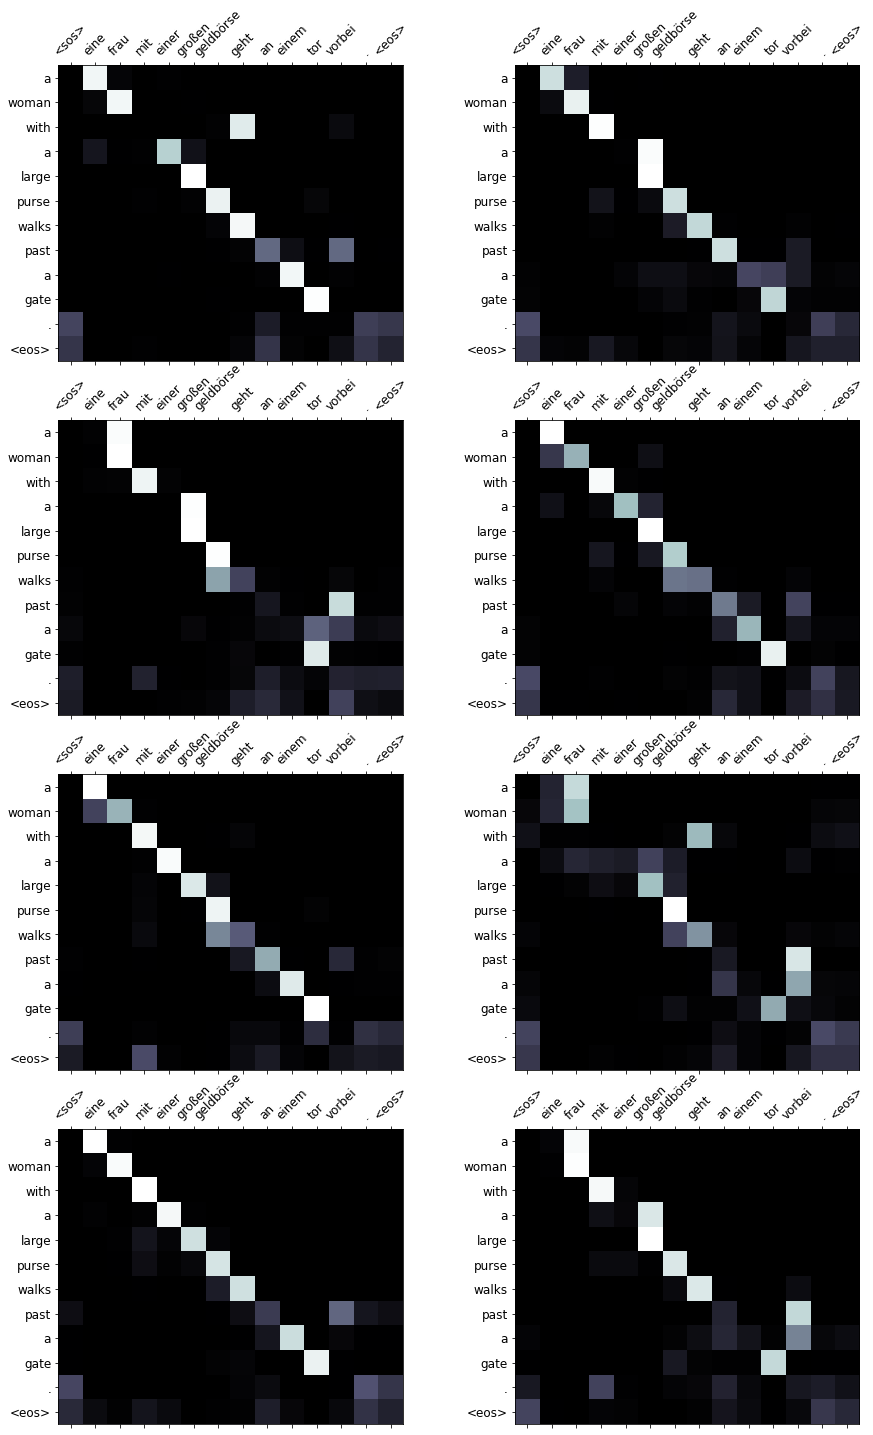

In [34]:
display_attention(src, translation, attention)

Next, let's get an example the model has not been trained on from the validation set.

In [35]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


The model translates it by switching *is running* to just *runs*, but it is an acceptable swap.

In [36]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'running', 'after', 'a', 'black', 'dog', '.', '<eos>']


Again, some heads pay full attention to "ein" whilst some pay no attention to it. Again, most of the heads seem to spread their attention over both the period and `<eos>` tokens in the source sentence when outputting the period and `<eos>` sentence in the predicted target sentence, though some seem to pay attention to tokens from near the start of the sentence.

/tmp/ipykernel_2508258/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_2508258/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


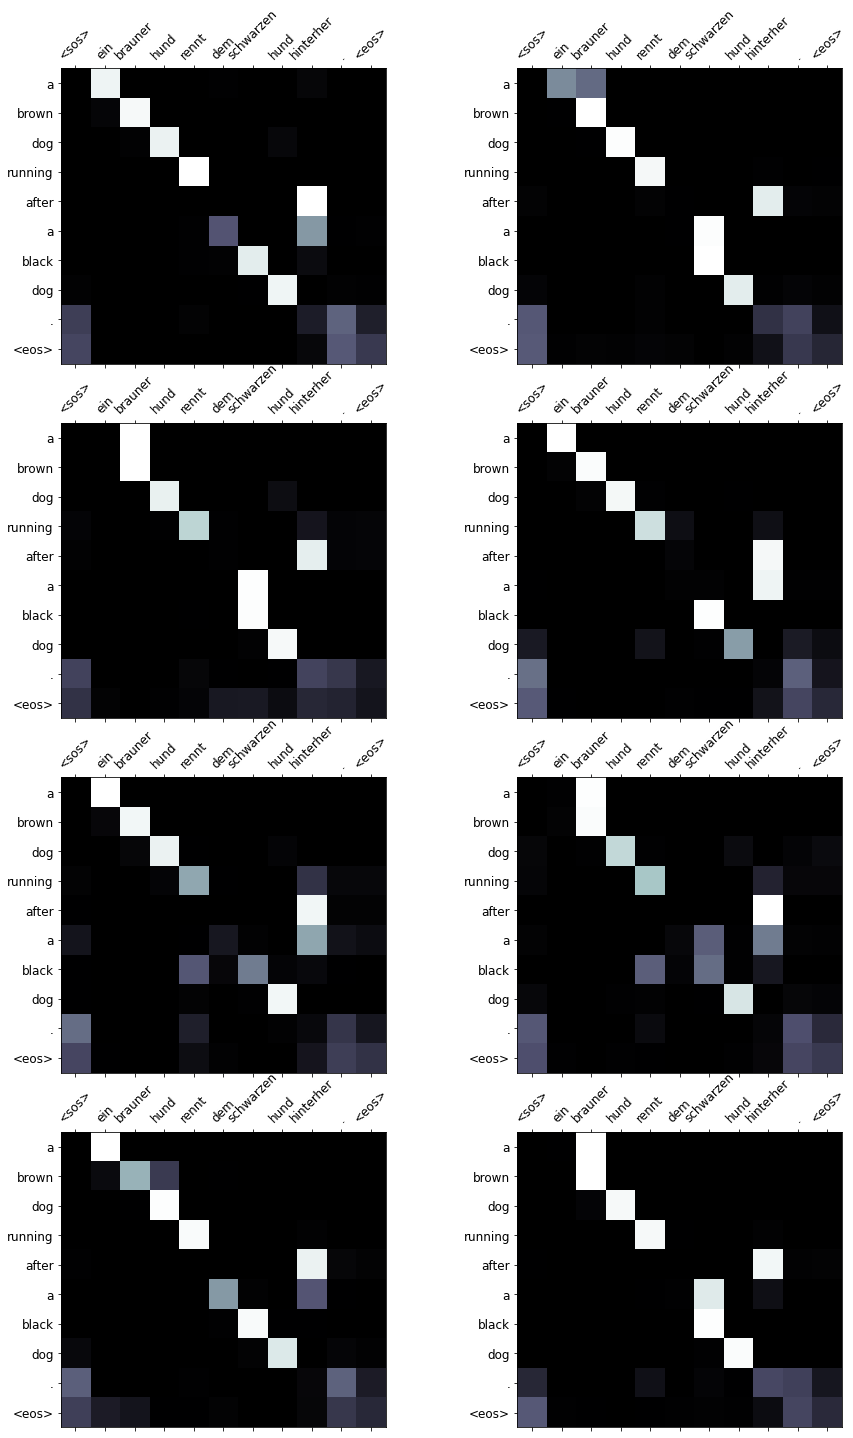

In [37]:
display_attention(src, translation, attention)

Finally, we'll look at an example from the test data.

In [38]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


A perfect translation!

In [39]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'her', 'son', 'enjoying', 'a', 'beautiful', 'day', 'outdoors', '.', '<eos>']


/tmp/ipykernel_2508258/3470126203.py:16: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'],
/tmp/ipykernel_2508258/3470126203.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+translation)


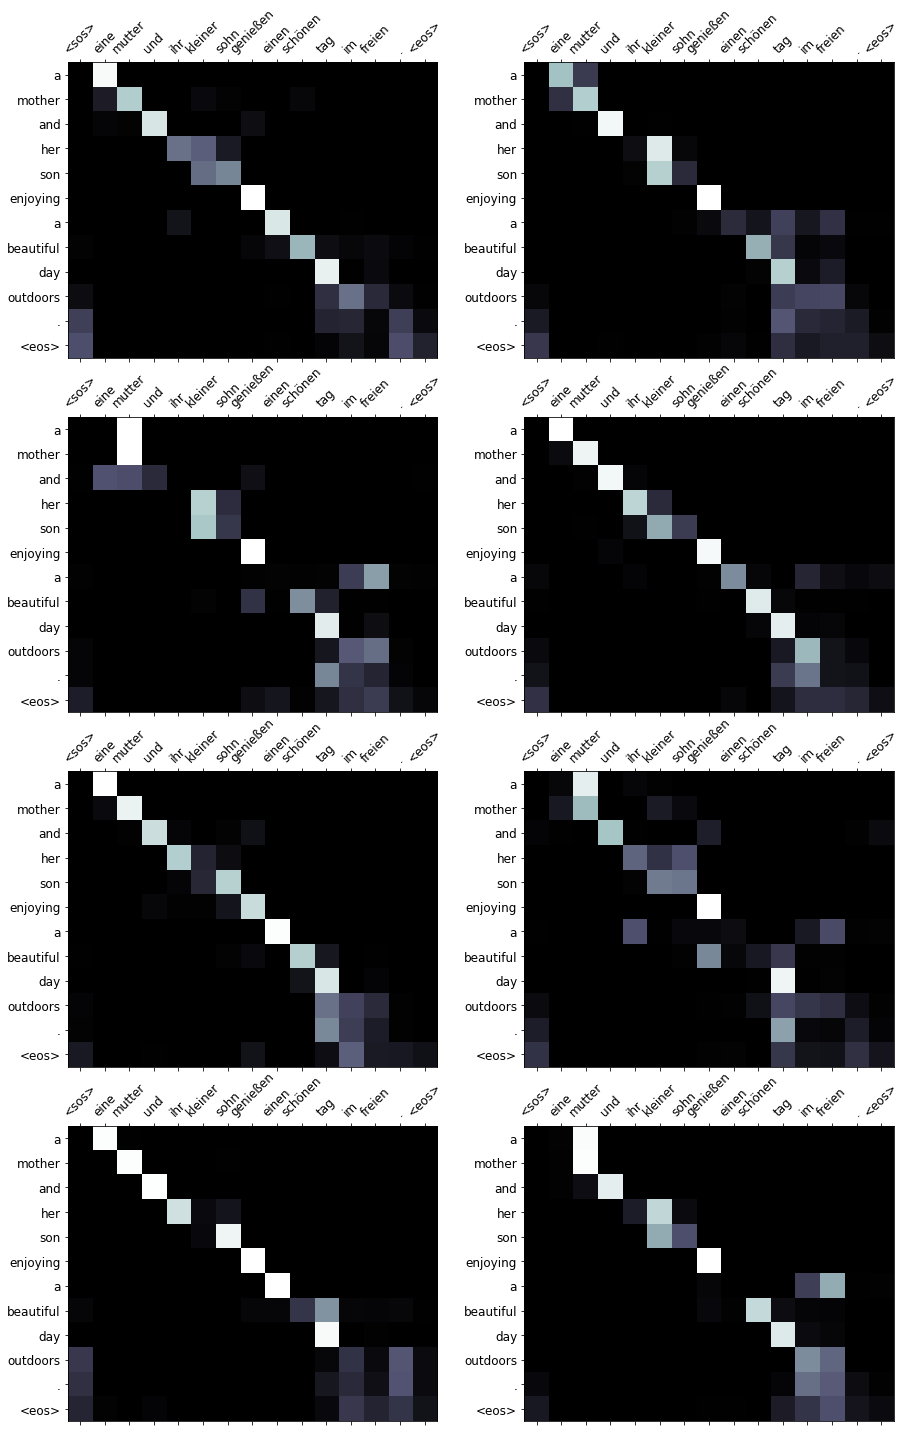

In [40]:
display_attention(src, translation, attention)

위에 보이는 바와 같이 src와 trg 사이의 attention matrix가 출력된다.

## BLEU

Finally we calculate the BLEU score for the Transformer.

In [41]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

BLEU score 측정을 통해 src와 trg 문장간의 유사도를 구한다.

We get a BLEU score of 36.52, which beats the ~34 of the convolutional sequence-to-sequence model and ~28 of the attention based RNN model. All this whilst having the least amount of parameters and the fastest training time!

In [42]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 35.47


Congratulations for finishing these tutorials! I hope you've found them useful.

If you find any mistakes or want to ask any questions about any of the code or explanations used, feel free to submit a GitHub issue and I will try to correct it ASAP.

## Appendix

The `calculate_bleu` function above is unoptimized. Below is a significantly faster, vectorized version of it that should be used if needed. Credit for the implementation goes to [@azadyasar](https://github.com/azadyasar).

In [43]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [44]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)